In [1]:
import sys, os
import networkx as nx

from pyEVCSlib import EVCSFixture

# get fixture
fx = EVCSFixture('runTest')
fx.out_dir = "out/script"
fx.fig_dir = "figs/script"

net, evcs = fx.read_inputs('Area 2')
print(evcs)

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 535: character maps to <undefined>

In [3]:

    
plot_network(net)

ModuleNotFoundError: No module named 'geopandas'

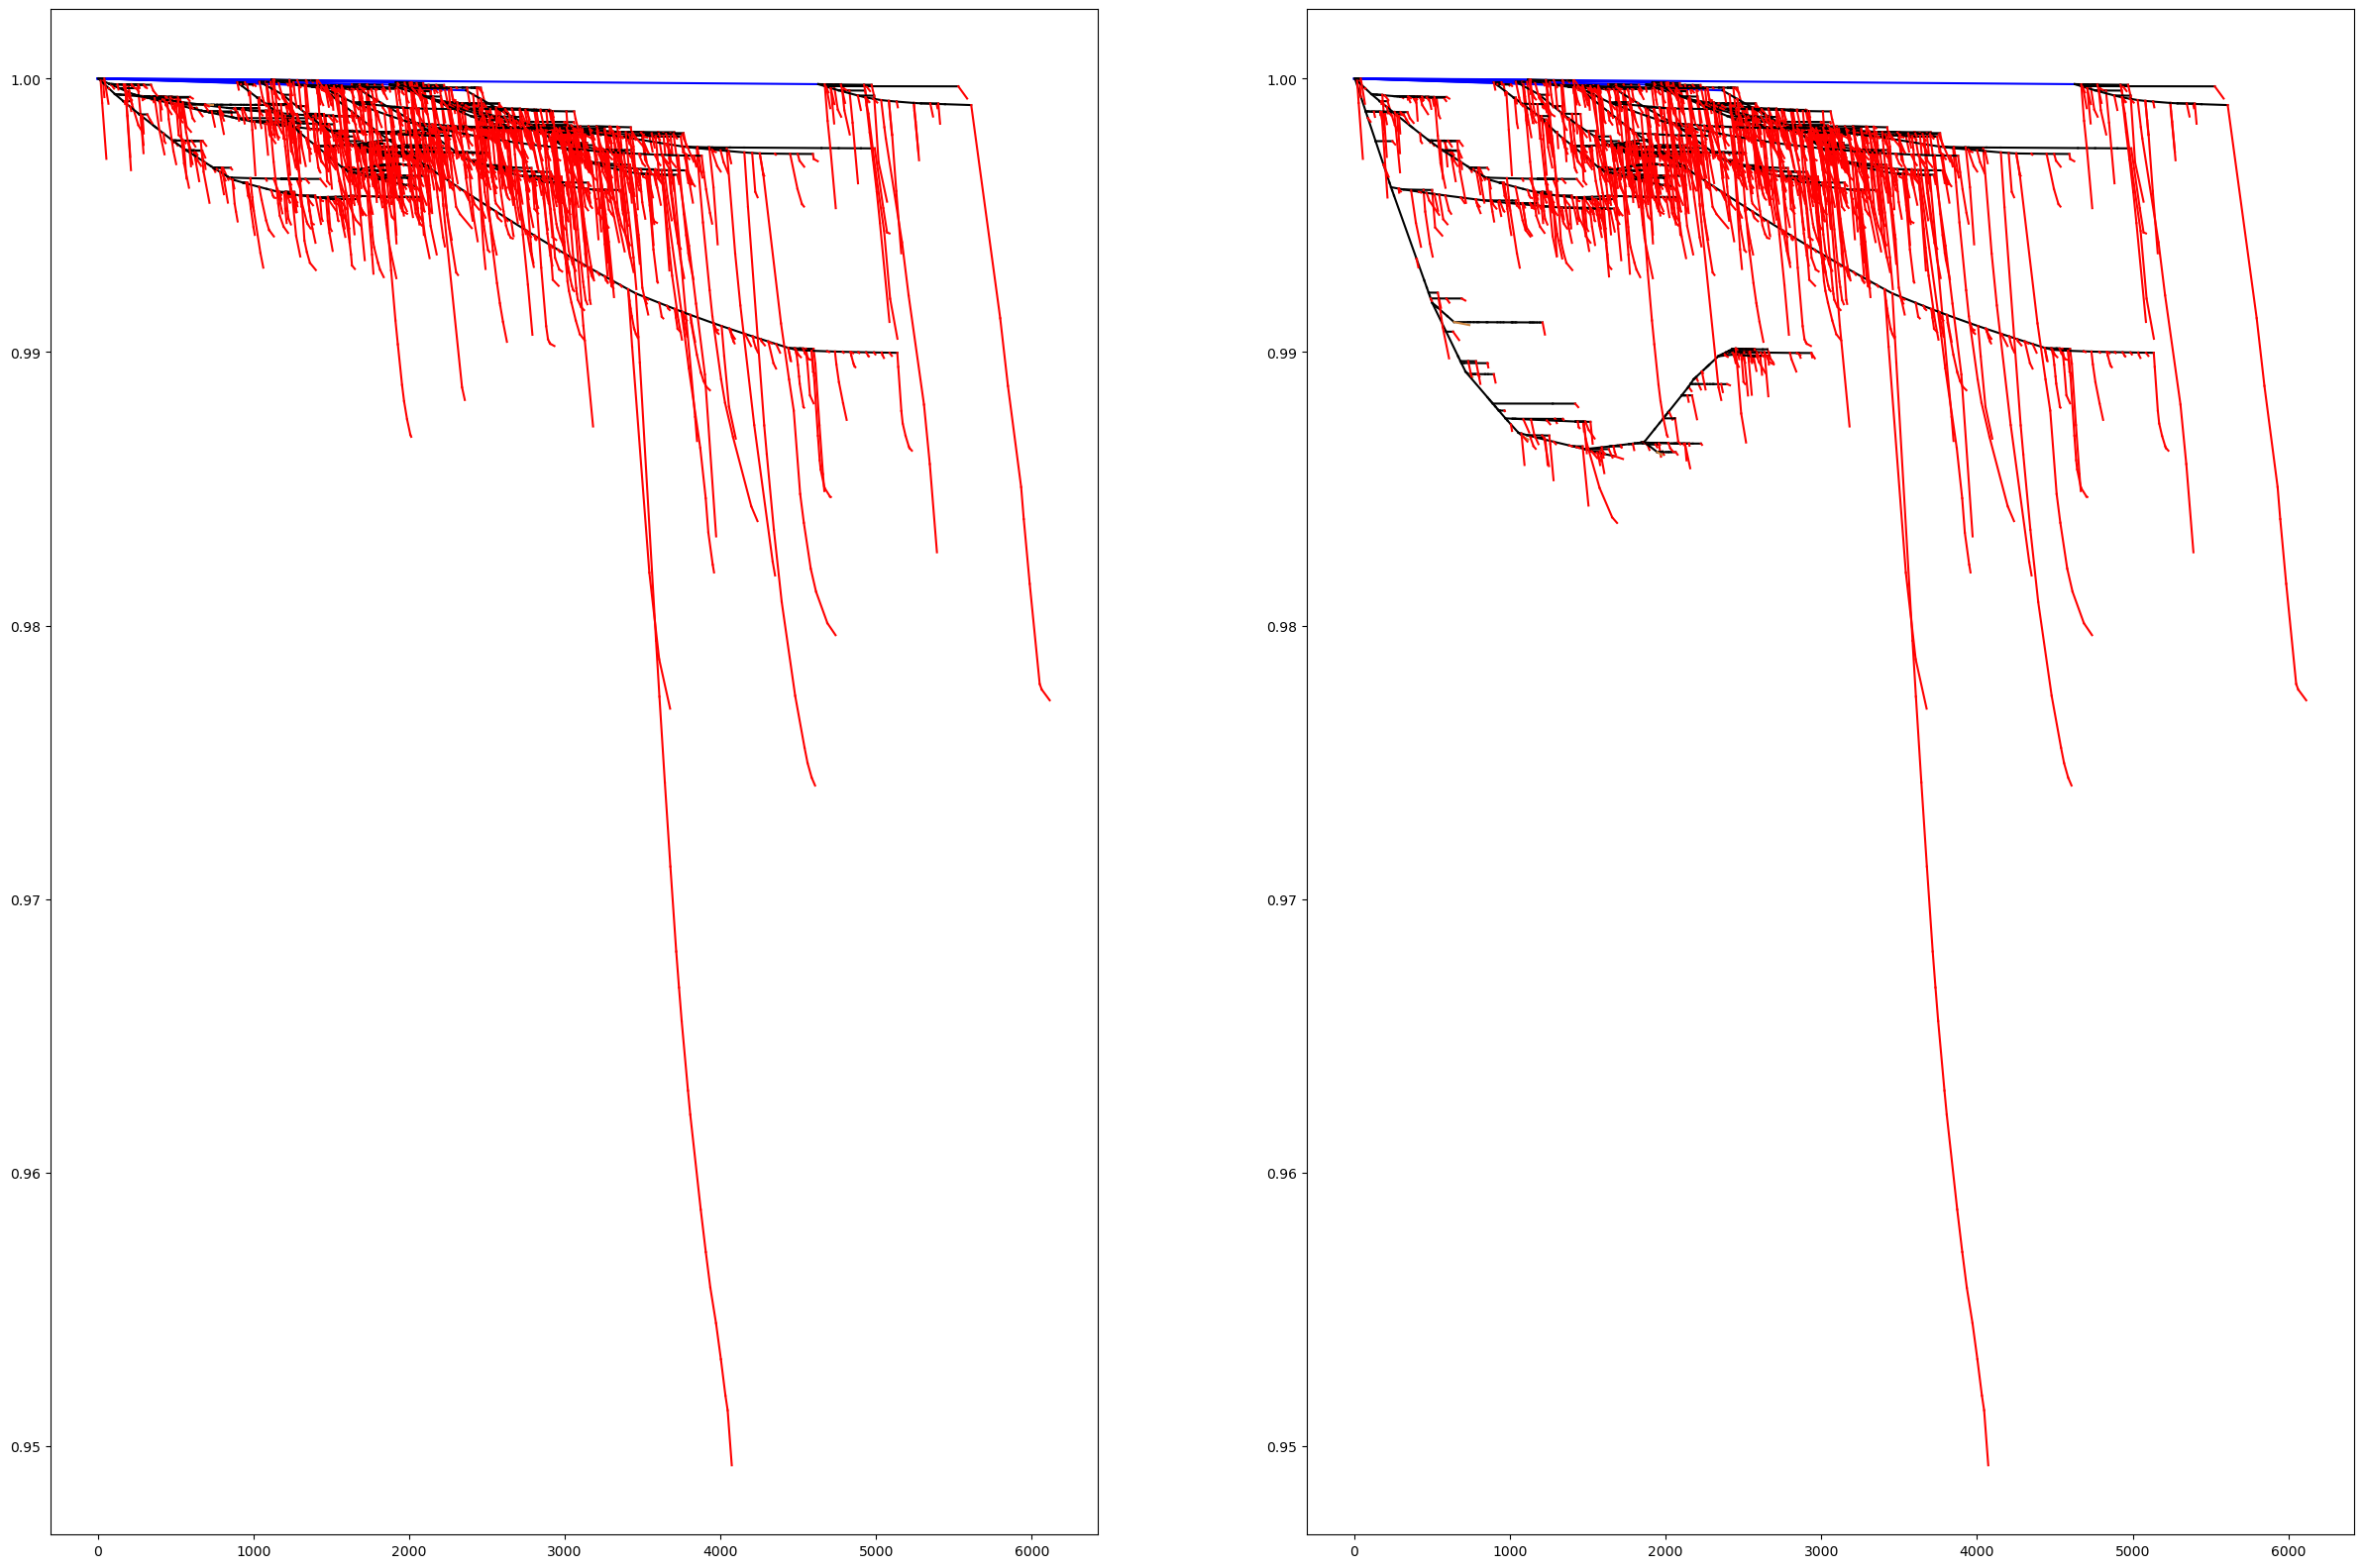

In [6]:
from pyUtilslib import powerflow
import matplotlib.pyplot as plt

d_nodes = {n:nx.shortest_path_length(net,n,sub,'length') for n in net}
color_ = {"E":"blue", "P":"black", "S":"red", "L":"peru"}

fig = plt.figure(figsize = (30,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

total_load = sum([net.nodes[n]["load"] for n in net if net.nodes[n]["label"]=='H'])

p_EV = 0
for n in net_fuel:
    net.nodes[n]["load"] = p_EV

powerflow(net)
v_nodes = {n:net.nodes[n]["voltage"] for n in net}
for edge in net.edges:
    ax1.plot([d_nodes[edge[0]],d_nodes[edge[1]]],
             [v_nodes[edge[0]],v_nodes[edge[1]]],
             color=color_[net.edges[edge]["label"]])
    
factor = 0.4
p_EV = factor * total_load / len(net_fuel)
for n in net_fuel:
    net.nodes[n]["load"] = p_EV

powerflow(net)
v_nodes = {n:net.nodes[n]["voltage"] for n in net}
for edge in net.edges:
    ax2.plot([d_nodes[edge[0]],d_nodes[edge[1]]],
             [v_nodes[edge[0]],v_nodes[edge[1]]],
             color=color_[net.edges[edge]["label"]])

In [4]:
"F3" in net

True